In [1]:
root = "~/dataset_with_refs"

In [2]:
import pandas as pd

abstracts_df = pd.read_csv(root + "/abstracts.csv", sep='\t')

In [2]:
import pandas as pd

sents_df = pd.read_csv(root + "/sentences.csv", sep='\t')

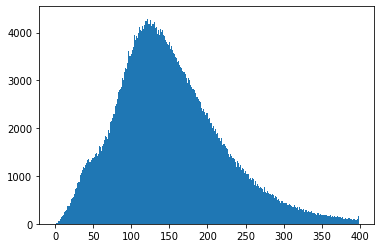

In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

res = Counter(list(sents_df['pmid'].values))

plt.hist(res.values(), bins=range(-1, 400))
plt.show()

In [9]:
from operator import itemgetter

min_key, min_count = min(res.items(), key=itemgetter(1))
print(min_key, min_count)

18995172 1


In [15]:
max_key, max_count = max(res.items(), key=itemgetter(1))
print(max_key, max_count)

21994484 5095


In [13]:
sents_df[sents_df['pmid'] == 18995172]['sentence'].values

array(['This special Symposium-in-Print issue of Bioorganic & Medicinal Chemistry Letters commemorates the 2008 Tetrahedron Young Investigator Award in Bioorganic & Medicinal Chemistry awarded to Benjamin F. Cravatt.'],
      dtype=object)

In [17]:
sents_df[sents_df['pmid'] == 21994484]['sentence'].values[:100]

array(['Hypocrea/Trichoderma is a taxonomically difficult, hyperdiverse genus with an extraordinarily high number of species, similar to Fusarium sensu lato.',
       'While in Fusarium the high species number is in part due to a heterogeneous assemblage of species based on the morphologically easily recognisable shape of macroconidia ( xref_bibr_R5 ), and Fusarium sensu stricto is more or less highly specialised to host plants ( xref_bibr_R57 ; xref_bibr_R46 ), the high diversity in Hypocrea/Trichoderma is a result of its hyperparasitic life style on other fungi. xref_bibr_R36 treated several aspects of the genus Hypocrea/Trichoderma, including the taxonomic history of the teleomorph genus Hypocrea and the anamorph genus Trichoderma, the development of the species concept, and important economic and social aspects.',
       'He explained the strategy of species identification and recognition followed in the underlying project.',
       'The project was designed to study the diversity 

In [4]:
import torch
import argparse
from tensorboardX import SummaryWriter
from torch.nn import BCELoss, BCEWithLogitsLoss
from torch.multiprocessing.spawn import spawn
from argparse import RawTextHelpFormatter
from torch.utils.data import DistributedSampler
from transformers import AdamW

from pysrc.review.utils import str2bool
import pysrc.review.config as cfg
from pysrc.review.train.train import train
from pysrc.review.train.eval import evaluate, evaluate_topic
from pysrc.review.model import Summarizer
from pysrc.review.utils import count_parameters, init_seed, DummyWriter
from pysrc.review.train.data import load_data, train_collate_fn, \
    eval_collate_fn, create_ddp_loader, create_loader, TrainDataset, EvalDataset
from pysrc.review.train.scheduler import NoamScheduler
from pysrc.review.train.preprocess import parse_sents, standardize, greedy_selection

In [ ]:
def preprocess_part(data, selection, is_tqdm):
    preprocessed_papers, preprocessed_abstracts, preprocessed_gold = [], [], []

    for _, (paper, abstract) in tqdm(data.items(), total=len(data), leave=True, disable=not is_tqdm):
        # prepare paper
        paper = parse_sents(paper)
        paper = standardize(paper)
        # prepare abstract
        abstract = parse_sents(abstract)
        abstract = standardize(abstract)

        if len(paper) < 30:
            continue
            
        # extract gold sentences
        if len(paper) > 50:
            cheating_ids = selection(paper, abstract, 50, stop=False)
            cheating_source = [paper[i] for i in cheating_ids]
            paper = cheating_source

        gold_ids = greedy_selection(paper, abstract, 6)
        
        if not gold_ids:
            continue

        # to text
        paper = ' '.join(paper)
        abstract = ' '.join(abstract)

        """
        print("paper:\n=======\n", paper)
        print("abstract:\n=======\n", abstract)
        print("n tokens:\n=======\n", len(TOKENIZER.encode(paper)))
        print(gold_ids)
        print('\n\n')
        """

        # add to preprocessed
        preprocessed_papers.append(paper)
        preprocessed_abstracts.append(abstract)
        preprocessed_gold.append(gold_ids)

    del data
    return preprocessed_papers, preprocessed_abstracts, preprocessed_gold

In [2]:
import pandas as pd



ModuleNotFoundError: No module named 'pandas'